## Novi smjer

In [1]:
import pandas as pd
from scipy.stats import entropy

df = pd.read_csv("data_final_6_glove.csv")

df["delta_auc"] = 0.0
df["p-value_greater"] = 0.0
df["p-value_less"] = 0.0
df["normality"] = 0.0
df["cos_glove_micro_avg_a_e"] = df[["cos_glove_micro_avg_a_e_"+str(i) for i in range(1,30)]].mean(axis=1)
df["clipped_auc"] = df[["auc_"+str(i) for i in range(9,30)]].mean(axis=1)

target_measure = "auc"
smjer = "a_e"

Calculate `delta_auc`

In [2]:
for dataset in ["Subjectivity", "CoLA", "TREC", "AG-News"]:
    for al_method in ["entropy", "core-set", "badge"]:
        for model_a in ["BERT", "ELECTRA", "RoBERTa"]:
            for model_e in ["BERT", "ELECTRA", "RoBERTa"]:
                for seed in range(20):
                    filtering = (df["dataset"] == dataset) & (df["al_method"] == al_method) & (df["model_a"] == model_a) & (df["model_e"] == model_e) & (df["seed"] == seed)
                    if smjer == "a_r":
                        filtering_random = (df["dataset"] == dataset) & (df["al_method"] == "random") & (df["model_e"] == model_e) & (df["seed"] == seed)
                    else:
                        filtering_random = (df["dataset"] == dataset) & (df["al_method"] == al_method) & (df["model_e"] == model_e) & (df["model_a"] == model_e) & (df["seed"] == seed)
                    df.loc[filtering, "delta_auc"] = (df[filtering][target_measure].iloc[0] - df[filtering_random][target_measure].iloc[0])

Using Lilliefors’ test to check if transfer AUC and random sampling AUC are normalni

In [3]:
from statsmodels.stats.diagnostic import lilliefors

for dataset in ["Subjectivity", "CoLA", "TREC", "AG-News"]:
    for al_method in ["entropy", "core-set", "badge"]:
        for model_a in ["BERT", "ELECTRA", "RoBERTa"]:
            for model_e in ["BERT", "ELECTRA", "RoBERTa"]:
                filtering = (df["dataset"] == dataset) & (df["al_method"] == al_method) & (df["model_a"] == model_a) & (df["model_e"] == model_e)
                if smjer == "a_r":
                    filtering_random = (df["dataset"] == dataset) & (df["al_method"] == "random") & (df["model_e"] == model_e)
                else:
                    filtering_random = (df["dataset"] == dataset) & (df["al_method"] == al_method) & (df["model_e"] == model_e) & (df["model_a"] == model_e)
                df.loc[filtering, "normality"] = min(lilliefors(df[filtering][target_measure])[1], lilliefors(df[filtering_random][target_measure])[1])

Using Wilcoxon signed-rank test if AUCs are not normal else paired t-test

In [4]:
from scipy.stats import ttest_rel
from scipy.stats import wilcoxon

for dataset in ["Subjectivity", "CoLA", "TREC", "AG-News"]:
    for al_method in ["entropy", "core-set", "badge"]:
        for model_a in ["BERT", "ELECTRA", "RoBERTa"]:
            for model_e in ["BERT", "ELECTRA", "RoBERTa"]:
                filtering = (df["dataset"] == dataset) & (df["al_method"] == al_method) & (df["model_a"] == model_a) & (df["model_e"] == model_e)
                if smjer == "a_r":
                    filtering_random = (df["dataset"] == dataset) & (df["al_method"] == "random") & (df["model_e"] == model_e)
                else:
                    filtering_random = (df["dataset"] == dataset) & (df["al_method"] == al_method) & (df["model_e"] == model_e) & (df["model_a"] == model_e)
                if df[filtering]["normality"].iloc[0] < 0.05:
                    df.loc[filtering, "p-value"] = wilcoxon(df[filtering][target_measure], df[filtering_random][target_measure])[1]
                else:
                    df.loc[filtering, "p-value"] = ttest_rel(df[filtering][target_measure], df[filtering_random][target_measure])[1]

In [7]:
df[df["al_method"] != "random"].head()

,Unnamed: 0.1,Unnamed: 0,dataset,al_method,model_a,model_e,seed,num_steps,num_labels,full_accuracy,...,representativeness_euk_28,diversity_euk_29,representativeness_euk_29,delta_auc,p-value_greater,p-value_less,normality,cos_glove_micro_avg_a_e,clipped_auc,p-value
60,60,60,Subjectivity,entropy,BERT,BERT,0,30,2,0.9625,...,0.080202,14.946650,0.085457,0.008793,0.0,0.0,0.292269,6.260543e-08,0.965887,9.112563e-11
61,61,61,Subjectivity,entropy,BERT,BERT,1,30,2,0.9625,...,0.078632,16.203524,0.081151,0.008069,0.0,0.0,0.292269,6.248211e-08,0.966808,9.112563e-11
62,62,62,Subjectivity,entropy,BERT,BERT,2,30,2,0.9625,...,0.085219,16.216206,0.079680,0.005302,0.0,0.0,0.292269,6.244100e-08,0.966825,9.112563e-11
63,63,63,Subjectivity,entropy,BERT,BERT,3,30,2,0.9625,...,0.087870,14.608082,0.086910,0.006155,0.0,0.0,0.292269,6.129002e-08,0.966177,9.112563e-11
64,64,64,Subjectivity,entropy,BERT,BERT,4,30,2,0.9625,...,0.085604,16.266912,0.081187,0.008543,0.0,0.0,0.292269,6.272875e-08,0.966197,9.112563e-11


In [8]:
avg_X = df[df["al_method"] != "random"].groupby(by=["dataset", "al_method", "model_a", "model_e"]).mean()
avg_X

Unnamed: 0.1  Unnamed: 0  seed  num_steps  \
dataset al_method model_a model_e                                              
AG-News badge     BERT    BERT           1629.5       429.5   9.5       40.0   
                          ELECTRA        1689.5       489.5   9.5       40.0   
                          RoBERTa        1749.5       549.5   9.5       40.0   
                  ELECTRA BERT           1649.5       449.5   9.5       40.0   
                          ELECTRA        1709.5       509.5   9.5       40.0   
...                                         ...         ...   ...        ...   
TREC    entropy   ELECTRA ELECTRA        1949.5       149.5   9.5       40.0   
                          RoBERTa        2009.5       209.5   9.5       40.0   
                  RoBERTa BERT           1909.5       109.5   9.5       40.0   
                          ELECTRA        1969.5       169.5   9.5       40.0   
                          RoBERTa        2029.5       229.5   9.5       40.0   

                                   num_labels  full_accuracy  \
dataset al_method model_a model_e                              
AG-News badge     BERT    BERT            4.0       0.928026   
                          ELECTRA         4.0       0.926316   
                          RoBERTa         4.0       0.938421   
                  ELECTRA BERT            4.0       0.928026   
                          ELECTRA         4.0       0.926316   
...                                       ...            ...   
TREC    entropy   ELECTRA ELECTRA         6.0       0.962000   
                          RoBERTa         6.0       0.968000   
                  RoBERTa BERT            6.0       0.968000   
                          ELECTRA         6.0       0.962000   
                          RoBERTa         6.0       0.968000   

                                   dataset_labels_entropy  stopping_index  \
dataset al_method model_a model_e                                           
AG-News badge     BERT    BERT                   2.000000            29.0   
                          ELECTRA                2.000000            29.0   
                          RoBERTa                2.000000            29.0   
                  ELECTRA BERT                   2.000000            29.0   
                          ELECTRA                2.000000            29.0   
...                                                   ...             ...   
TREC    entropy   ELECTRA ELECTRA                2.383374            29.0   
                          RoBERTa                2.383374            29.0   
                  RoBERTa BERT                   2.383374            29.0   
                          ELECTRA                2.383374            29.0   
                          RoBERTa                2.383374            29.0   

                                        auc        f1  ...  \
dataset al_method model_a model_e                      ...   
AG-News badge     BERT    BERT     0.888124  0.912211  ...   
                          ELECTRA  0.821719  0.885263  ...   
                          RoBERTa  0.883949  0.914566  ...   
                  ELECTRA BERT     0.882904  0.905474  ...   
                          ELECTRA  0.840808  0.898513  ...   
...                                     ...       ...  ...   
TREC    entropy   ELECTRA ELECTRA  0.882909  0.961500  ...   
                          RoBERTa  0.870053  0.963400  ...   
                  RoBERTa BERT     0.899267  0.964500  ...   
                          ELECTRA  0.875122  0.960600  ...   
                          RoBERTa  0.890078  0.968900  ...   

                                   representativeness_euk_28  \
dataset al_method model_a model_e                              
AG-News badge     BERT    BERT                      0.095134   
                          ELECTRA                   0.095134   
                          RoBERTa                   0.095134   
                  ELECTRA BERT  

# Correlation

In [11]:
from scipy.stats import spearmanr, pearsonr
import statsmodels.api as sm
import matplotlib.pyplot as plt


for dataset in ["Subjectivity", "CoLA", "AG-News", "TREC"]:
    auc = df[(df["al_method"] != "random") & (df["model_a"] != df["model_e"]) & (df["dataset"] == dataset)]["delta_auc"]
    cos_dist = df[(df["al_method"] != "random") & (df["model_a"] != df["model_e"]) & (df["dataset"] == dataset)]["cos_glove_micro_avg_a_e"]

    print(f"{dataset}")
    if min(lilliefors(auc)[1], lilliefors(cos_dist)[1]) < 0.05:
        print(spearmanr(auc, cos_dist))
    else:
        print(pearsonr(auc, cos_dist))

Subjectivity
SpearmanrResult(correlation=-0.11048572698424168, pvalue=0.03613118829217294)
CoLA
SpearmanrResult(correlation=-0.18868429958319147, pvalue=0.00031825345328310935)
AG-News
SpearmanrResult(correlation=-0.2707244436600672, pvalue=1.823327191439323e-07)
TREC
SpearmanrResult(correlation=-0.3800513160384904, pvalue=8.145228457712582e-14)


## Transfer

### Negative

In [14]:
from collections import Counter 
import numpy as np

columns = np.array(list(avg_X[(avg_X["p-value"] < 0.05) & (avg_X["delta_auc"] < 0)].query("model_a != model_e")["delta_auc"].index))

print(f"dataset -> {Counter(columns[:,0])}")
print(f"al_method -> {Counter(columns[:,1])}")
print(f"model_a -> {Counter(columns[:,2])}")
print(f"model_e -> {Counter(columns[:,3])}")
print(f"model pairs -> {Counter(map(tuple, columns[:,2:]))}")
print(f"dataset+method -> {Counter(map(tuple, columns[:,[0,1]]))}")

dataset -> Counter({'TREC': 8, 'AG-News': 7, 'CoLA': 2})
al_method -> Counter({'entropy': 11, 'core-set': 4, 'badge': 2})
model_a -> Counter({'BERT': 7, 'RoBERTa': 6, 'ELECTRA': 4})
model_e -> Counter({'ELECTRA': 9, 'BERT': 4, 'RoBERTa': 4})
model pairs -> Counter({('BERT', 'ELECTRA'): 5, ('RoBERTa', 'ELECTRA'): 4, ('RoBERTa', 'BERT'): 2, ('ELECTRA', 'BERT'): 2, ('ELECTRA', 'RoBERTa'): 2, ('BERT', 'RoBERTa'): 2})
dataset+method -> Counter({('TREC', 'entropy'): 6, ('AG-News', 'entropy'): 3, ('AG-News', 'badge'): 2, ('AG-News', 'core-set'): 2, ('CoLA', 'entropy'): 2, ('TREC', 'core-set'): 2})


### Neutral

In [15]:
from collections import Counter 
import numpy as np

columns = np.array(list(avg_X[avg_X["p-value"] >= 0.05].query("model_a != model_e")["delta_auc"].index))

print(f"dataset -> {Counter(columns[:,0])}")
print(f"al_method -> {Counter(columns[:,1])}")
print(f"model_a -> {Counter(columns[:,2])}")
print(f"model_e -> {Counter(columns[:,3])}")
print(f"model pairs -> {Counter(map(tuple, columns[:,2:]))}")
#print(f"dataset+model -> {Counter(map(tuple, columns[:,[0,3]]))}")
print(f"dataset+method -> {Counter(map(tuple, columns[:,[0,1]]))}")

dataset -> Counter({'CoLA': 8, 'AG-News': 4, 'TREC': 3})
al_method -> Counter({'core-set': 10, 'entropy': 3, 'badge': 2})
model_a -> Counter({'ELECTRA': 6, 'BERT': 5, 'RoBERTa': 4})
model_e -> Counter({'RoBERTa': 8, 'BERT': 4, 'ELECTRA': 3})
model pairs -> Counter({('BERT', 'RoBERTa'): 4, ('ELECTRA', 'RoBERTa'): 4, ('ELECTRA', 'BERT'): 2, ('RoBERTa', 'BERT'): 2, ('RoBERTa', 'ELECTRA'): 2, ('BERT', 'ELECTRA'): 1})
dataset+method -> Counter({('CoLA', 'core-set'): 5, ('TREC', 'core-set'): 3, ('AG-News', 'core-set'): 2, ('AG-News', 'entropy'): 2, ('CoLA', 'badge'): 2, ('CoLA', 'entropy'): 1})


### Positive

In [16]:
from collections import Counter 
import numpy as np

columns = np.array(list(avg_X[(avg_X["p-value"] < 0.05) & (avg_X["delta_auc"] >= 0)].query("model_a != model_e")["delta_auc"].index))

print(f"dataset -> {Counter(columns[:,0])}")
print(f"al_method -> {Counter(columns[:,1])}")
print(f"model_a -> {Counter(columns[:,2])}")
print(f"model_e -> {Counter(columns[:,3])}")
print(f"model pairs -> {Counter(map(tuple, columns[:,2:]))}")
#print(f"dataset+model -> {Counter(map(tuple, columns[:,[0,3]]))}")
print(f"dataset+method -> {Counter(map(tuple, columns[:,[0,1]]))}")

dataset -> Counter({'Subjectivity': 18, 'CoLA': 8, 'AG-News': 7, 'TREC': 7})
al_method -> Counter({'badge': 20, 'core-set': 10, 'entropy': 10})
model_a -> Counter({'ELECTRA': 14, 'RoBERTa': 14, 'BERT': 12})
model_e -> Counter({'BERT': 16, 'RoBERTa': 12, 'ELECTRA': 12})
model pairs -> Counter({('ELECTRA', 'BERT'): 8, ('RoBERTa', 'BERT'): 8, ('BERT', 'RoBERTa'): 6, ('ELECTRA', 'RoBERTa'): 6, ('BERT', 'ELECTRA'): 6, ('RoBERTa', 'ELECTRA'): 6})
dataset+method -> Counter({('Subjectivity', 'badge'): 6, ('Subjectivity', 'core-set'): 6, ('Subjectivity', 'entropy'): 6, ('TREC', 'badge'): 6, ('AG-News', 'badge'): 4, ('CoLA', 'badge'): 4, ('CoLA', 'entropy'): 3, ('AG-News', 'core-set'): 2, ('AG-News', 'entropy'): 1, ('CoLA', 'core-set'): 1, ('TREC', 'core-set'): 1})


## Regular AL

### Negative

In [10]:
from collections import Counter 
import numpy as np

columns = np.array(list(avg_X[(avg_X["p-value"] < 0.05) & (avg_X["delta_auc"] < 0)].query("model_a == model_e")["delta_auc"].index))

print(f"dataset -> {Counter(columns[:,0])}")
print(f"al_method -> {Counter(columns[:,1])}")
print(f"model_a -> {Counter(columns[:,2])}")
print(f"model_e -> {Counter(columns[:,3])}")
print(f"model pairs -> {Counter(map(tuple, columns[:,2:]))}")

dataset -> Counter({'AG-News': 1, 'TREC': 1})
al_method -> Counter({'entropy': 1, 'core-set': 1})
model_a -> Counter({'ELECTRA': 1, 'BERT': 1})
model_e -> Counter({'ELECTRA': 1, 'BERT': 1})
model pairs -> Counter({('ELECTRA', 'ELECTRA'): 1, ('BERT', 'BERT'): 1})


### Neutral

In [11]:
from collections import Counter 
import numpy as np

columns = np.array(list(avg_X[avg_X["p-value"] >= 0.05].query("model_a == model_e")["delta_auc"].index))

print(f"dataset -> {Counter(columns[:,0])}")
print(f"al_method -> {Counter(columns[:,1])}")
print(f"model_a -> {Counter(columns[:,2])}")
print(f"model_e -> {Counter(columns[:,3])}")
print(f"model pairs -> {Counter(map(tuple, columns[:,2:]))}")

dataset -> Counter({'AG-News': 3, 'CoLA': 3, 'TREC': 3})
al_method -> Counter({'core-set': 4, 'entropy': 4, 'badge': 1})
model_a -> Counter({'RoBERTa': 4, 'ELECTRA': 3, 'BERT': 2})
model_e -> Counter({'RoBERTa': 4, 'ELECTRA': 3, 'BERT': 2})
model pairs -> Counter({('RoBERTa', 'RoBERTa'): 4, ('ELECTRA', 'ELECTRA'): 3, ('BERT', 'BERT'): 2})


### Positive

In [12]:
from collections import Counter 
import numpy as np

columns = np.array(list(avg_X[(avg_X["p-value"] < 0.05) & (avg_X["delta_auc"] >= 0)].query("model_a == model_e")["delta_auc"].index))

print(f"dataset -> {Counter(columns[:,0])}")
print(f"al_method -> {Counter(columns[:,1])}")
print(f"model_a -> {Counter(columns[:,2])}")
print(f"model_e -> {Counter(columns[:,3])}")
print(f"model pairs -> {Counter(map(tuple, columns[:,2:]))}")

dataset -> Counter({'Subjectivity': 9, 'CoLA': 6, 'AG-News': 5, 'TREC': 5})
al_method -> Counter({'badge': 11, 'core-set': 7, 'entropy': 7})
model_a -> Counter({'BERT': 9, 'ELECTRA': 8, 'RoBERTa': 8})
model_e -> Counter({'BERT': 9, 'ELECTRA': 8, 'RoBERTa': 8})
model pairs -> Counter({('BERT', 'BERT'): 9, ('ELECTRA', 'ELECTRA'): 8, ('RoBERTa', 'RoBERTa'): 8})


# Method vs Model

In [11]:
from scipy.stats import wilcoxon

entropy = df[(df["model_a"] != df["model_e"]) & (df["al_method"] == "entropy")]["cos_glove_micro_avg_a_e"]
core_set = df[(df["model_a"] != df["model_e"]) & (df["al_method"] == "core-set")]["cos_glove_micro_avg_a_e"]
badge = df[(df["model_a"] != df["model_e"]) & (df["al_method"] == "badge")]["cos_glove_micro_avg_a_e"]

print(entropy.mean(), entropy.std())
print(core_set.mean(), core_set.std())
print(badge.mean(), badge.std())

0.20229520372639612 0.04970151339062314
0.21640238167407594 0.05434596413176929
0.1965586244968975 0.04625258924939767


In [12]:
from statsmodels.stats.diagnostic import lilliefors

print(lilliefors(entropy))
print(lilliefors(core_set))
print(lilliefors(badge))

(0.2903624472257964, 0.0009999999999998899)
(0.26925430592791383, 0.0009999999999998899)
(0.2835612751402248, 0.0009999999999998899)


In [14]:
# core-set > entropy > badge
print(wilcoxon(core_set, entropy, alternative="greater"))
print(wilcoxon(core_set, badge, alternative="greater"))
print(wilcoxon(entropy, badge, alternative="greater"))
print(wilcoxon(entropy, core_set, alternative="less"))
print(wilcoxon(badge, core_set, alternative="less"))
print(wilcoxon(badge, entropy, alternative="less"))

WilcoxonResult(statistic=115425.0, pvalue=1.2816108330989624e-80)
WilcoxonResult(statistic=115440.0, pvalue=1.1667435013261717e-80)
WilcoxonResult(statistic=111617.0, pvalue=1.3164216915289953e-70)
WilcoxonResult(statistic=15.0, pvalue=1.2816108330989624e-80)
WilcoxonResult(statistic=0.0, pvalue=1.1667435013261717e-80)
WilcoxonResult(statistic=3823.0, pvalue=1.3164216915289953e-70)


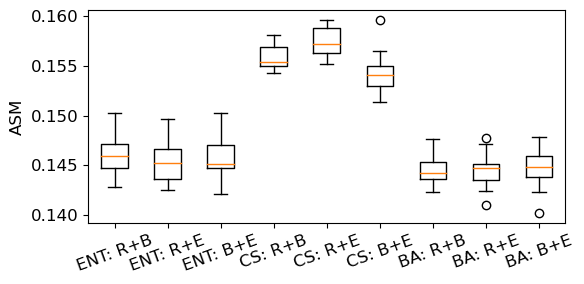

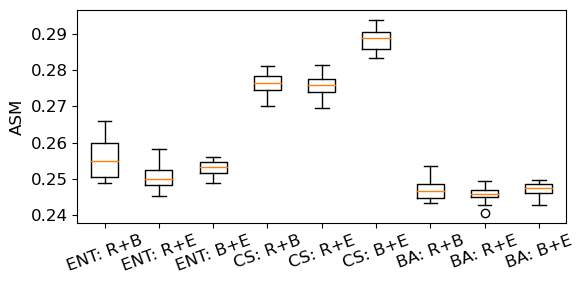

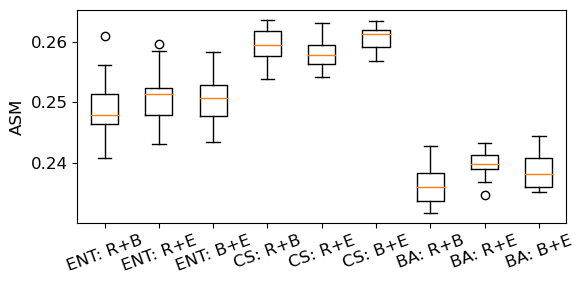

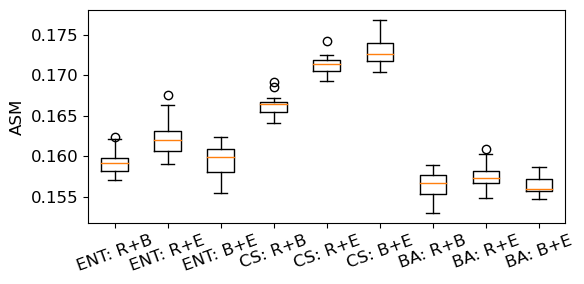

In [33]:
import matplotlib.pyplot as plt
from itertools import combinations

plt.rcParams["figure.figsize"] = (6,3)
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'figure.autolayout': True})
names = {"entropy": "ENT", "core-set": "CS", "badge": "BA"}
colors = ["green"]*3 + ["blue"]*3 + ["orange"]*3

for data in ["Subjectivity", "CoLA", "TREC", "AG-News"]:
    boxes = []
    for al_method in ["entropy", "core-set", "badge"]:
        for model_a, model_e in combinations(["RoBERTa", "BERT", "ELECTRA"], 2):
            temp = df[(df["al_method"] == al_method) & (df["model_e"] == model_e) & (df["model_a"] == model_a) & (df["dataset"] == data)]["cos_glove_micro_avg_a_e"]
            boxes.append((f"{names[al_method]}: {model_a[0]}+{model_e[0]}", temp))
    plt.boxplot([x[1] for x in boxes], labels=[x[0] for x in boxes])
    #plt.title(data)
    plt.ylabel("ASM")
    plt.xticks(rotation=20)
    plt.subplots_adjust(0)
    plt.savefig(f'model-vs-method-{data}.pdf')
    plt.show()


# Temporal

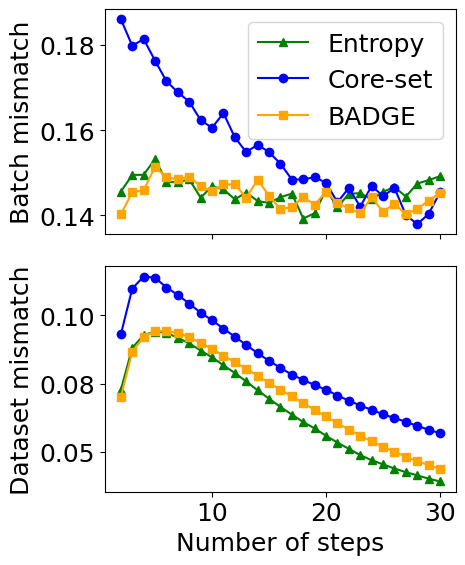

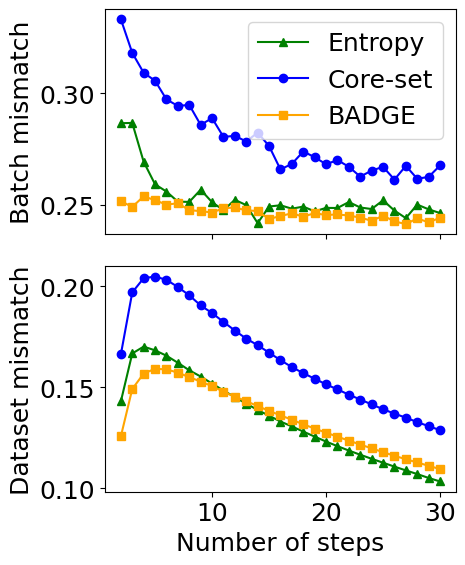

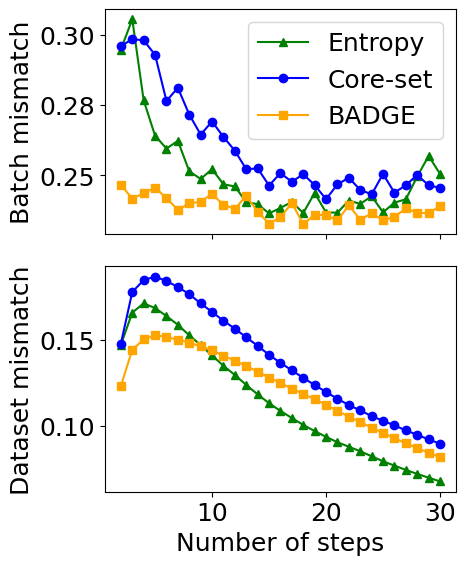

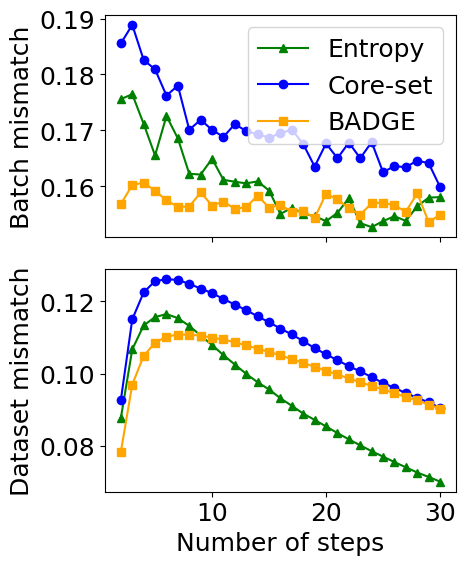

In [30]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import FormatStrFormatter

plt.rcParams["figure.figsize"] = (5,6)
plt.rcParams.update({'font.size': 18})
plt.rcParams.update({'figure.autolayout': True})
colors = {"entropy":"green", "core-set":"blue", "badge":"orange"}
marker = {"entropy":"^", "core-set":"o", "badge":"s"}
labels = {"entropy":"Entropy", "core-set":"Core-set", "badge":"BADGE"}

for dataset in ["Subjectivity", "CoLA", "TREC", "AG-News"]:
    fig, axes = plt.subplots(2, 1, sharex=True, sharey="row")
    axes[0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    axes[1].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    for i, mjera in enumerate(["cos_glove_micro_avg_a_e", "cos_glove_micro_avg_a_e_accum"]):
        dic = {}
        dic_std = {}
        for method in ["entropy", "core-set", "badge"]:
            data = []
            std = []
            for time in range(1,30):
                data.append(df[(df["dataset"] == dataset) & (df["model_a"] != df["model_e"]) & (df["al_method"] == method)][mjera+"_"+str(time)].mean())
                std.append(df[(df["dataset"] == dataset) & (df["al_method"] == method)][mjera+"_"+str(time)].std())
            dic[method] = data
            dic_std[method] = std
            axes[i].plot(range(2,31), data, marker=marker[method], color=colors[method], label=labels[method])

        if i == 0:
            axes[i].legend()
        if mjera == "cos_glove_micro_avg_a_e":
            axes[i].set_ylabel("Batch mismatch")
        if mjera == "cos_glove_micro_avg_a_e_accum":
            axes[i].set_ylabel("Dataset mismatch")

    axes[1].set_xlabel("Number of steps")
    fig.savefig(f'temporal-batch-{dataset}.pdf')
    fig.show()